#### Реализуем градиентый бустинг - CatBoost.  

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_scor
from catboost import CatBoostRegressor, Pool

df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [99]:
clmns = df.columns.tolist()
target, ocean = clmns.index('median_house_value'), clmns.index('ocean_proximity')
clmns[target], clmns[ocean] = clmns[ocean], clmns[target]
df = df[clmns]
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY,342200.0
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,INLAND,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,INLAND,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,INLAND,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,INLAND,84700.0


### Найдем возможные выбросы с помощью ящика с усами

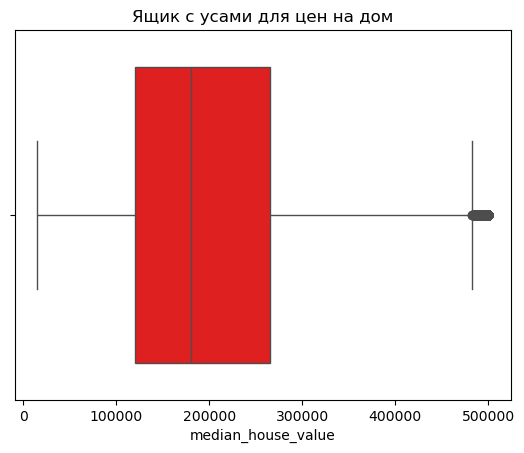

In [24]:
import seaborn as sns

sns.boxplot(x=df['median_house_value'], color='red')
plt.title('Ящик с усами для цен на дом')
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.3, random_state=13)

## Этот код автоматически обучит модель и подставит в нее лучшие параметры

In [57]:
from catboost import Pool

#  категориальные признаки в дфе
cat_features = ['ocean_proximity']

#  обучающий Ppol чтобы нормально передать категлриальный признак в дф
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# создание  первичной пустой модели
grad_descnt = CatBoostRegressor(
    iterations=1000,
    early_stopping_rounds=50,
    verbose=False,
    random_seed=42
)

# параметры для модели
param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 4, 5, 7],
    'bagging_temperature': [0, 0.2, 0.5, 1],
    'random_strength': [0, 1, 2, 3]
}


grad_descnt.randomized_search(
    param_distributions,
    X=train_pool,
    cv=5,
    n_iter=20,
    partition_random_seed=42,
    calc_cv_statistics=True,
    stratified=False
)

#  лучшие параметры
grad_descnt.get_params


bestTest = 45863.89374
bestIteration = 988

0:	loss: 45863.8937375	best: 45863.8937375 (0)	total: 16.4s	remaining: 5m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 44828.93555
bestIteration = 745

1:	loss: 44828.9355465	best: 44828.9355465 (1)	total: 43.9s	remaining: 6m 35s

bestTest = 56879.00332
bestIteration = 999

2:	loss: 56879.0033179	best: 44828.9355465 (1)	total: 1m	remaining: 5m 40s

bestTest = 44423.16527
bestIteration = 998

3:	loss: 44423.1652748	best: 44423.1652748 (3)	total: 1m 33s	remaining: 6m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 45419.77271
bestIteration = 258

4:	loss: 45419.7727080	best: 44423.1652748 (3)	total: 1m 50s	remaining: 5m 32s

bestTest = 44987.93789
bestIteration = 999

5:	loss: 44987.9378925	best: 44423.1652748 (3)	total: 2m 47s	remaining: 6m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 46195.3332
bestIteration = 369

6:	loss: 46195.3331957	best: 44423.1652748 (3)	total: 3m

<bound method CatBoost.get_params of <catboost.core.CatBoostRegressor object at 0x000002E2CABFD3D0>>

In [107]:
# обучение
grad_descnt.fit(X_train, y_train, cat_features=['ocean_proximity'])

In [110]:
y_pred = grad_descnt.predict(X_test)

In [112]:
pd.DataFrame({"Предсказание модели": y_pred, "Реальное значение": y_test}).head()

,Предсказание модели,Реальное значение
2973,94593.796024,130100.0
14432,229512.838072,229400.0
13916,82035.108477,82600.0
18848,55183.028395,53100.0
2208,114279.899276,107800.0


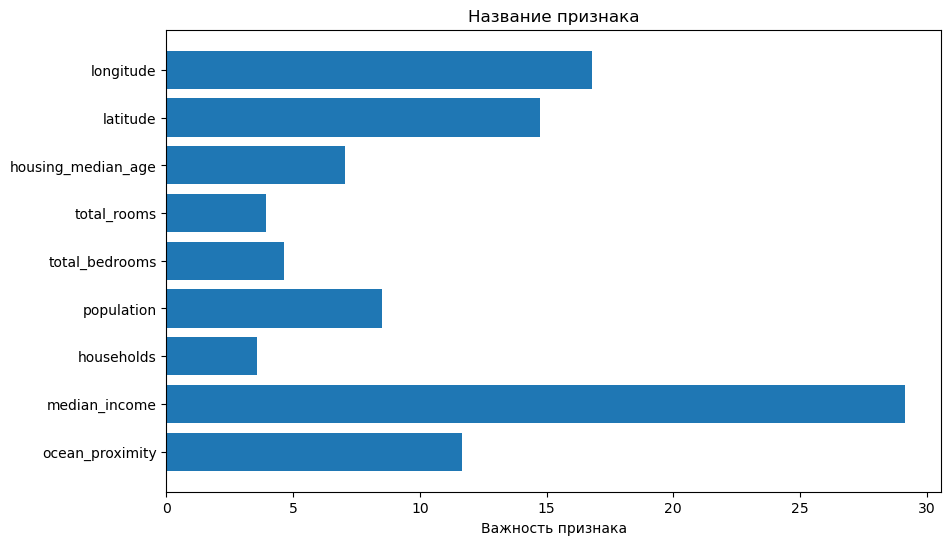

In [126]:
# график важности признаков - показывает, какие столбцы сильнее всего влияют на предсказание модели (чем длинее горизонт. линия, тем сильнее модель полагается на признак)
importances = grad_descnt.get_feature_importance()
feature_names = grad_descnt.feature_names_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Важность признака")
plt.title("Название признака")
plt.gca().invert_yaxis() # поворачиваем на 90 градусов стандартный график
plt.show()

In [116]:
print(f"RMSE = {root_mean_squared_error(y_test, y_pred)}")
print(f"R2 = {r2_score(y_test, y_pred)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred)}")

RMSE = 46202.19685309772
R2 = 0.8405946142689872
MAE = 30077.15615583883
